### This is adpated from kaggle alexnet code: https://www.kaggle.com/virajbagal/stanford-dogs-alexnet-paper-implementation-pytorch  

In [30]:
# need to pip install albumentations in terminal first 

In [31]:
# import modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader  
from albumentations import RandomCrop, HorizontalFlip, CenterCrop, Compose, Normalize
from albumentations.pytorch.transforms import ToTensor
from sklearn.metrics import accuracy_score

In [32]:
print(os.listdir('stanford-dogs-dataset/'))

['.DS_Store', 'images', 'annotations']


In [33]:
# Load annotation and image paths 

annot_path = 'stanford-dogs-dataset/annotations/Annotation'
image_path = 'stanford-dogs-dataset/images/Images'
# there is an invisible DS_STORE file in it. The original number of files is 120, but here it is 121
assert len(os.listdir(annot_path)) == len(os.listdir(image_path))

In [34]:
# valid records breed name and num of images for that breed in data set 
valid = []

for element in os.listdir(image_path):
    if 'DS_Store' in element:
        pass
    else:
        breed = element.split('-')[1]
        images = len(os.listdir(os.path.join(image_path,element)))
        valid.append((breed, images))

Total number of images : 20580


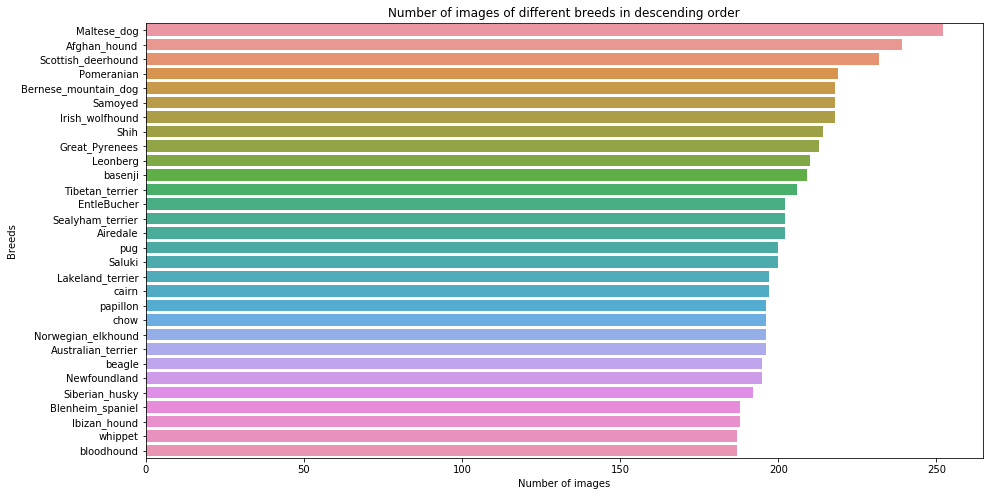

In [35]:
df = pd.DataFrame(valid, columns = ['Breeds', 'Number of images'])
print('Total number of images :', df['Number of images'].sum())
# visulization, not important 
plt.figure(figsize=(15,8))
plt.title('Number of images of different breeds in descending order')
sns.barplot(x = 'Number of images', y = 'Breeds', data = df.sort_values('Number of images', ascending = False).head(30))

In [37]:
# subset in original code only includes the top five breeds of dogs with more images than others, 
# but here we include all.
subset = df.sort_values('Number of images', ascending = False)['Breeds'][:5].values.tolist()

In [47]:
valid = []

for element in os.listdir(image_path):
    if 'DS_Store' in element:
        continue
    if element.split('-')[1] in subset:
        for img_id in os.listdir(os.path.join(image_path, element)):
            path = os.path.join(element, img_id)
            label = element.split('-')[1]
            valid.append((path, label))
        
df = pd.DataFrame(valid, columns = ['Path', 'Label'])
print('Shape of dataframe :', df.shape)

Shape of dataframe : (1160, 2)


In [48]:
# df records the path and label for images 
df.head()

,Path,Label
0,n02092002-Scottish_deerhound/n02092002_2981.jpg,Scottish_deerhound
1,n02092002-Scottish_deerhound/n02092002_6503.jpg,Scottish_deerhound
2,n02092002-Scottish_deerhound/n02092002_11105.jpg,Scottish_deerhound
3,n02092002-Scottish_deerhound/n02092002_6729.jpg,Scottish_deerhound
4,n02092002-Scottish_deerhound/n02092002_12544.jpg,Scottish_deerhound


In [49]:
# [0.485, 0.456, 0.406] is the normalized mean value of ImageNet, 
# and [0.229, 0.224, 0.225] denotes the std of ImageNet.

normalise = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def aug1():
    return Compose([RandomCrop(height = 224, width = 224, p = 1.0), HorizontalFlip(p = 0.5), \
                    ToTensor(normalize = normalise)], p = 1)

def aug2():
    return Compose([ToTensor(normalize = normalise)], p = 1)

train_aug = aug1()
valid_aug = aug2()

In [50]:
# PCA Color Augmentation This is in Alexnet paper. 
def PCAColorAug(image, category = 'Tensor'):
    if type(image) == torch.Tensor:
        image = image.numpy()
        image = np.moveaxis(image, 0, 2)
    
    
    img_reshaped = image.reshape(-1, 3).astype('float32')
    mean, std = np.mean(img_reshaped, 0), np.std(img_reshaped, 0)
    img_rescaled = (img_reshaped - mean)/std
    cov_matrix = np.cov(img_rescaled, rowvar = False) # Covariant matrix of reshaped image.  Output is 3*3 matrix
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix) # Compute Eigen Values and Eigen Vectors of the covariant matrix. eigen_vec is 3*3 matrix with eigen vectors as column. 
    alphas = np.random.normal(loc = 0, scale = 0.1, size = 3)
    vec1 = alphas*eigen_val
    valid = np.dot(eigen_vec, vec1) # Matrix multiplication
    pca_aug_norm_image = img_rescaled + valid
    pca_aug_image = pca_aug_norm_image*std + mean
    aug_image = np.maximum(np.minimum(pca_aug_image, 255), 0).astype('uint8')
    if category == 'Tensor':
        return torch.from_numpy(aug_image.reshape(3,256,256))
    else:
        return aug_image.reshape(256,256,3)
    


In [51]:
# a table where entry = 1 if that index associated with the breed, 0 otherwise
labels = pd.get_dummies(df['Label'])

In [52]:
import torchvision.transforms as transforms

class StanfordDogs(Dataset):
    def __init__(self, transform1, transform2, X, Y, objective = 'train'):
        self.X = X
        self.Y = Y
        self.train_transform = transform1
        self.valid_transform = transform2
        self.objective = objective
        
    def __getitem__(self, idx):
        path = self.X['Path'][idx]
        label = self.Y.iloc[idx, :].values
        img = cv2.imread(os.path.join(image_path, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Shortest side of image is scaled to 256 pixels and the other side is scaled so as to maintain aspect ratio
        
        h, w, _ = img.shape
        
        if h <= w:
            aspect_ratio = w/h
            dim = (256, int(256*aspect_ratio))
            img = cv2.resize(img, dim)
        else:
            aspect_ratio = h/w
            dim = (int(256*aspect_ratio), 256)
            img = cv2.resize(img, dim)
            
        img = CenterCrop(height = 256, width = 256, p = 1)(image = img)['image']
        
        if self.objective == 'train':
            random = np.random.uniform(size = 1)
            if random < 0.5:                            # PCA Augmentation carried out only 50 percent of time
                img = PCAColorAug(img, category = 'numpy')
                
            augmented = self.train_transform(image = img)
            img = augmented['image']
            
            return img, label
        
        elif ((self.objective == 'validation') |  (self.objective == 'test')):
            img = cv2.resize(img, (224, 224))
            augmented = self.valid_transform(image = img)
            img = augmented['image']  
            
            return img, label
        
    
    def __len__(self):
        return len(self.X)

In [53]:
# TRAIN-TEST SPLIT 
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df, labels, test_size = 0.25, random_state = 5, stratify = df['Label'])
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.20, random_state = 5, stratify = train_X['Label'])

In [54]:
print(len(train_X))
print(len(val_X))

696
174


In [55]:
#reset index 
train_X.reset_index(drop = True, inplace = True)
val_X.reset_index(drop = True, inplace = True)

train_y.reset_index(drop = True, inplace = True)
val_y.reset_index(drop = True, inplace = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

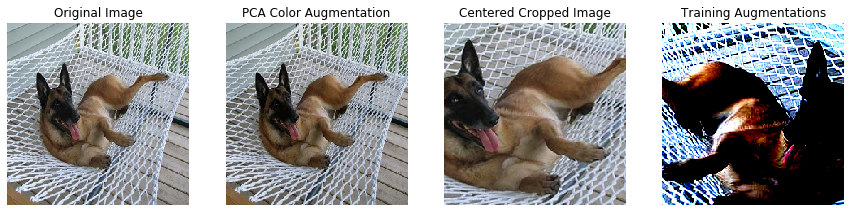

In [56]:
# SHOW IMAGE, NOT IMPORTANT 
image = cv2.imread(image_path + '/n02105162-malinois/n02105162_6625.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image, (256,256))

aug_image = PCAColorAug(image1, category = 'numpy')
cropped_img = CenterCrop(height = 256, width = 256, p = 1)(image = image)['image']
image2 = cv2.resize(cropped_img, (224,224))
image3 = train_aug(image = cropped_img)['image']
image3 = image3.numpy()
image3 = np.moveaxis(image3, 0, 2)
image3 = cv2.resize(image3, (224,224))

plt.figure(figsize = (15, 10))
plt.subplot(1,4,1)
plt.imshow(image1)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,4,2)
plt.imshow(aug_image)
plt.title('PCA Color Augmentation')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(image2)
plt.title('Centered Cropped Image')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(image3)
plt.title('Training Augmentations')
plt.axis('off')


In [57]:
# load data 
BATCH_SIZE = 128

def loader(data_X, data_Y, batch_size = BATCH_SIZE, obj = 'train'):
    data = StanfordDogs(train_aug, valid_aug, X = data_X, Y = data_Y, objective = obj)
    loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True)
    
    return loader

train_loader = loader(train_X, train_y, batch_size = BATCH_SIZE)
val_loader = loader(val_X, val_y, batch_size = BATCH_SIZE, obj = 'validation')

In [58]:
# Loading Pretrained AlexNet Model

import torchvision.models as models
import torch
import torch.nn as nn

alexnet = models.alexnet(pretrained = False)
# Can't load pretrained parameters
#alexnet.load_state_dict(torch.load('alexnet/alexnet.pth'))

In [59]:
# 120 breeds of dogs  
alexnet.classifier[6] = nn.Linear(4096, 5)

In [60]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = SGD(alexnet.classifier.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0005) # We train only on classifier head. We keep the weights in feature head as it is.
scheduler = ReduceLROnPlateau(optimizer, patience = 4, factor = 0.1, mode = 'min')
criterion = nn.CrossEntropyLoss()

In [61]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
    
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [62]:
# Model Training and Evaluation
epochs = 20
losses_df = {'train_loss' : [], 'val_loss' : [], 'val_acc' : []}
num_batches = len(train_X)//BATCH_SIZE
val_num_batches = len(val_X)//BATCH_SIZE
best_loss = np.inf


alexnet = alexnet.to(device)

for epoch in range(epochs):
    print('Epoch :', epoch)
    scheduler.step(epoch)
    print('Learning rate :', get_lr(optimizer))
    print('Training for epoch {}'.format(epoch))
    val_outputs = []
    loss = 0
    vloss = 0
    # train model 
    alexnet.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = batch
        img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
        output = alexnet(img)
        batch_loss = criterion(output, torch.max(label, 1)[1])
        batch_loss.backward()
        optimizer.step()
        loss +=batch_loss.item()
    # calculate training loss 
    train_loss = loss/num_batches
    print('Training loss for epoch {} is {:.4f}'.format(epoch, train_loss))
    losses_df['train_loss'].append(train_loss)
    print('Validation for epoch {}'.format(epoch))
    with torch.no_grad():
        alexnet.eval()
    
        for i, batch in enumerate(val_loader):
            img, label = batch
            img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
            output = alexnet(img)
            batch_loss = criterion(output, torch.max(label, 1)[1])
            output = output.detach().cpu().numpy()
            label = label.detach().cpu().numpy()
            val_outputs.extend(np.argmax(output, 1))
            vloss += batch_loss.item()
            
    val_loss = vloss/val_num_batches
    print('Validation loss for epoch {} is {:.4f}'.format(epoch, val_loss))
    losses_df['val_loss'].append(val_loss)
    val_labels = list(np.argmax(np.array(val_y), 1))
    acc = accuracy_score(val_outputs, val_labels)
    print('Accuracy for epoch {} is {:.4f}'.format(epoch, acc))
    losses_df['val_acc'].append(acc)
    
    if val_loss <= best_loss:
        print('Validation loss has reduced from {:.4f} to {:.4f}'.format(best_loss, val_loss))
        print('Saving model')
        best_loss = val_loss
        torch.save(alexnet.state_dict(), 'alexnet_finetuning.pth')
        

Epoch : 0
Learning rate : 0.01
Training for epoch 0
Training loss for epoch 0 is 1.9314
Validation for epoch 0
Validation loss for epoch 0 is 3.2159
Accuracy for epoch 0 is 0.2069
Validation loss has reduced from inf to 3.2159
Saving model
Epoch : 1
Learning rate : 0.01
Training for epoch 1
Training loss for epoch 1 is 1.9313
Validation for epoch 1
Validation loss for epoch 1 is 3.2162
Accuracy for epoch 1 is 0.2126
Epoch : 2
Learning rate : 0.01
Training for epoch 2
Training loss for epoch 2 is 1.9306
Validation for epoch 2
Validation loss for epoch 2 is 3.2165
Accuracy for epoch 2 is 0.2299
Epoch : 3
Learning rate : 0.01
Training for epoch 3
Training loss for epoch 3 is 1.9296
Validation for epoch 3
Validation loss for epoch 3 is 3.2156
Accuracy for epoch 3 is 0.2184
Validation loss has reduced from 3.2159 to 3.2156
Saving model
Epoch : 4
Learning rate : 0.01
Training for epoch 4
Training loss for epoch 4 is 1.9291
Validation for epoch 4
Validation loss for epoch 4 is 3.2171
Accuracy